In [1]:
import numpy as np
from math import*
#import matplotlib.pyplot 
import matplotlib.pyplot as plt
import random
import scipy
import scipy.stats
from numpy import polynomial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
#from scipy.optimize import NonlinearConstraint

In [2]:
class ContextBandit:
    
    def __init__(self, S_space, X , Theta, sigma,seed=None):
        #Attention! X est une liste de longueur K, chaque élément est un tableau donnant les phi(s) pour 
        #chaque s dans un intervalle des contextes S (ici discrétisé par S_space)
        #Theta est un tableau K x d, ou chanque ligne représente les theta permettant de générer la fonction 
        #f de l'action k.
        
        self.S_space = np.copy(S_space)
        
        self.n_S = len(self.S_space)
        
        self.X = np.copy(X)
        
        self.Theta = np.copy(Theta)
        
        self.sigma = sigma
        
        self.random = np.random.RandomState(seed)
        
        #Nombre d'actions de l'espace discrétisé
        #self.K = X.shape[0]
        self.K = Theta.shape[0]
        self.d = Theta.shape[1]
        
        #self.means contiendra les moyennes (f) pour chacune des deux actions
        self.means = np.zeros((self.K, self.n_S))
        
        for i in range(self.K):
            self.means[i] = self.X[i].dot(self.Theta[i])
        
        # pour conserver le regret (indicateur de la performance)
        
        self.k_star  = np.zeros(self.n_S,dtype=int)
        
        self.gaps = np.zeros((self.K, self.n_S))
        
        for i in range(self.n_S):
            self.k_star[i] = np.argmax(self.means[:,i])
            self.gaps[:,i] = self.means[self.k_star[i],i] - self.means[:,i]
        
        #self.k_star contient l'action optimale dépendante du contexte
        #self.gaps contient les gaps (tableau de dimension K x n_space)
        
        self.regret = []
        
    def play(self, k, s):
        #joue l'action k au contexte s donnée, Attention, s est un index
        self.regret.append(self.gaps[k,s])
        
        # Reward est la moyenne de l'action k au contexte s plus un bruit gaussien
        reward = self.means[k,s] + self.random.normal(0, self.sigma)
        
        return reward
    
    def get_cumulative_regret(self):
        
        return np.cumsum(self.regret)
    

In [3]:
def kernel_ts_sampling_contextuel(bandit, T, Lambda, R, seed=None, plot=False, bw = 1):
    '''
    Reçoit un bandit contextue, un horizon T
    Lambda =...
    R = upper bound sur le sigma du bruit
    bw = bandwidth pour le noyau RBF du GaussianProcessRegressor
    '''
    
    generation = np.random.RandomState(seed)
    
    bandwidth = bw
    
    #On préparer en X et un Y pour chaque bras pour le Gaussianprocess.
    X, y = [], []
    
    for k in range(bandit.K):
        X.append([])
        y.append([])
    
    #On doit initialiser un f_hat et un SIGMA_hat pour chacun des k bras
    
    f_hat = np.ones((bandit.K,bandit.n_S))*7
    
    SIGMA_hat = []
    for k in range(bandit.K):
        SIGMA_hat.append([])
    
    for k in range(bandit.K):
       # SIGMA_hat[k] = np.eye(bandit.n_S)
        SIGMA_hat[k] = np.zeros((bandit.n_S,bandit.n_S))
        
    #préparation d'une liste de f_tilde près à recevoir les nombres échantillonnées pour chaque action k
    f_tilde = np.zeros((bandit.K,bandit.n_S))
    
   # for (k in range(bandit.K)):
   #     f_tilde.append([])
    
    for t in range(T):
        
        #print(t)
        #print(X)
        
        #échantillonner un f_tilde pour chacune des actions.
        
        for k in range(bandit.K):
            f_tilde[k] = generation.multivariate_normal(f_hat[k], SIGMA_hat[k])
        
        if(plot):
            #plt.plot(bandit.S_space, f_tilde[0], color='red', label='action 1')
            #plt.plot(bandit.S_space, f_tilde[1], color='blue', label='action 2')
            #plt.title("Graphiques de la simulation de la fonction f_tilde \n des rewards après {} tour(s)".format(t))
            plt.plot(bandit.S_space, f_hat[0], color='red', label='action 1')
            plt.plot(bandit.S_space, f_hat[1], color='blue', label='action 2')
            plt.title("Graphiques de la simulation de la fonction f_hat \n des rewards après {} tour(s)".format(t))
            plt.xlabel('Contexte')
            plt.ylabel('Moyenne des rewards')
            plt.legend()
            plt.show()
        
        #on génère le contexte aléatoirement, (c'est un index de la discrétisation de l'espace S)
        s = generation.randint(low=0,high=bandit.n_S)
        
        # l'agent infère l'action optimale selon le contexte s
        
        k_t = np.argmax(f_tilde[:,s])
        #print(f_tilde[:,s])
        
        #l'agent jour l'action qu'il pressent optimale
        
        y_t = bandit.play(k_t,s)
        
        # mise à jour du X et du y pour l'action jouée
        
        X[k_t].append([bandit.S_space[s]])
        
        #print(t)
        #print(k_t)
        #print(bandit.S_space[s])
        
        y[k_t].append(y_t)
        
        # nouvelle régression pour l'action jouée
        X_arr, y_arr = np.array(X[k_t]), np.array(y[k_t])
            
        model = GaussianProcessRegressor(RBF(length_scale=bandwidth), alpha=Lambda, optimizer=None)
        
        model.fit(X_arr, y_arr)
        
        # mise à jour de f_hat et SIGMA_hat pour l'action jouée
        
        f_hat[k_t], k_lambda = model.predict(bandit.S_space[:, None], return_cov=True)
        
        SIGMA_hat[k_t] = (R/Lambda)*k_lambda

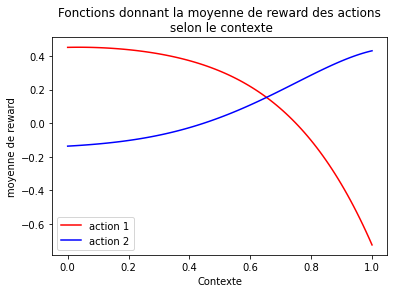

In [4]:
#Préparation d'un contexte pour tester l'algorithme de kernel Thompson Sampling sur des bandits contextuels.

space = np.linspace(0,1,100)

features_1 = np.array([[1, x, x**2, x**3, x**4, x**5] for x in space])
features_2 = np.array([[1, x, x**2, x**3, x**4, x**5] for x in space])

features = [features_1,features_2]

random = np.random.RandomState(999)
theta_1 = random.uniform(-1,1,6)
theta_2 = random.uniform(-1,1,6)


theta_1 = theta_1/np.linalg.norm(theta_1,2)
theta_2 = theta_2/np.linalg.norm(theta_2,2)

Theta=np.array([theta_1,theta_2])

sigma = 0.1

bandit = ContextBandit(space, features, Theta, sigma, 42)

f_1 = np.dot(features[0], Theta[0])
f_2 = np.dot(features[1], Theta[1])

plt.plot(space,f_1,color='red',label='action 1')
plt.plot(space,f_2,color='blue',label='action 2')
plt.title('Fonctions donnant la moyenne de reward des actions\n selon le contexte')
plt.xlabel('Contexte')
plt.ylabel('moyenne de reward')

plt.legend()
plt.show()

#print(bandit.gaps)

T=100
Lambda=sigma**2
R=sigma

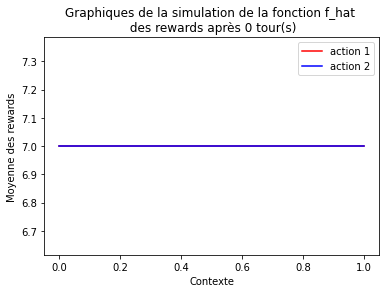

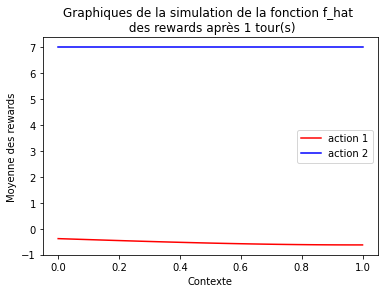

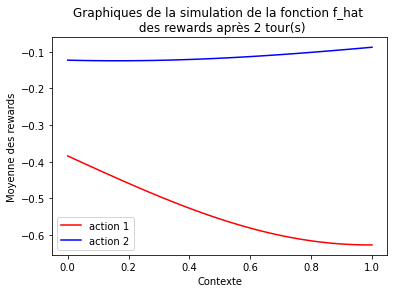

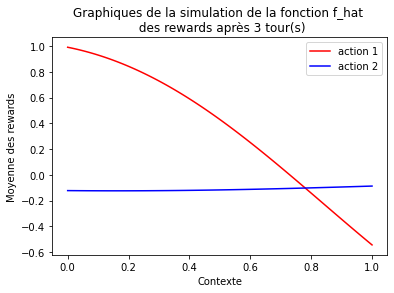

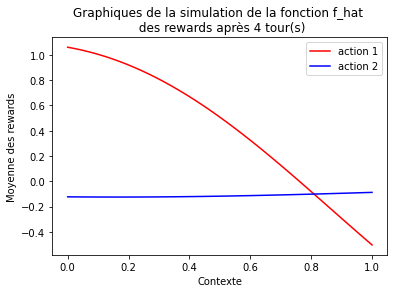

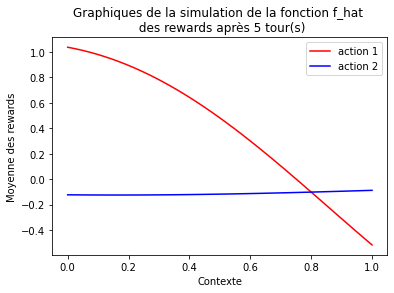

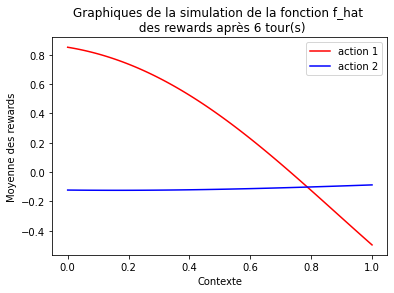

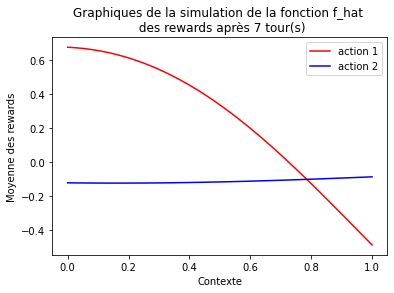

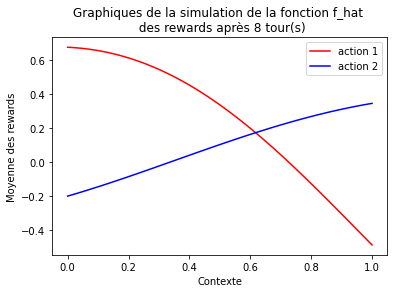

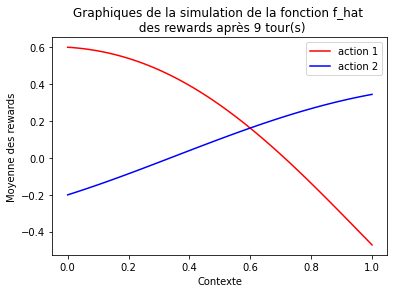

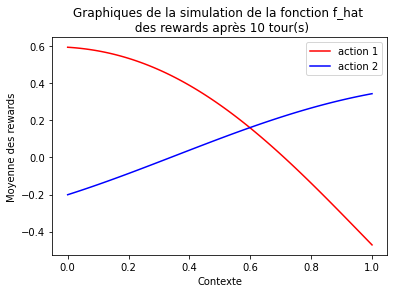

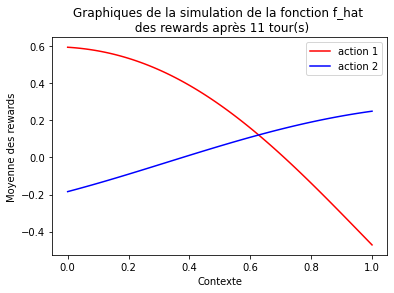

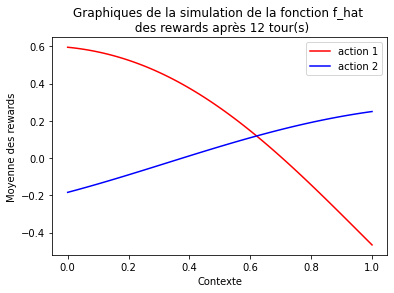

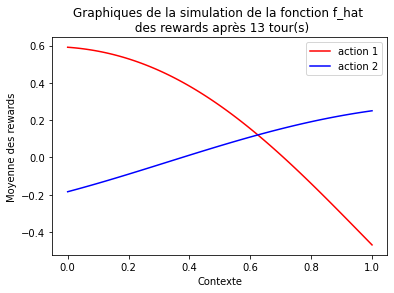

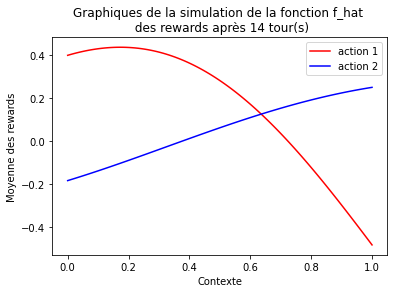

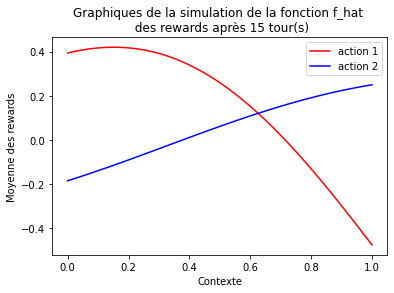

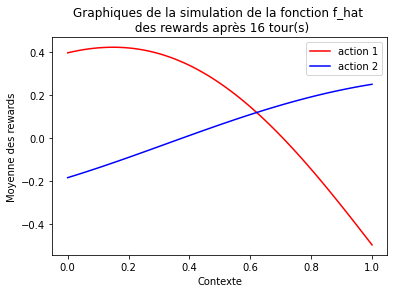

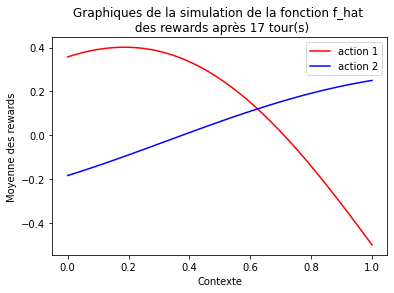

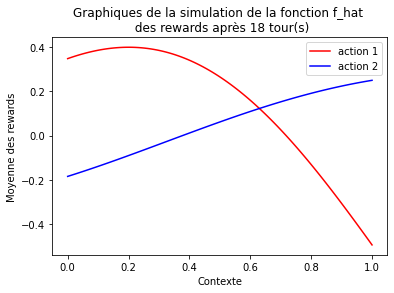

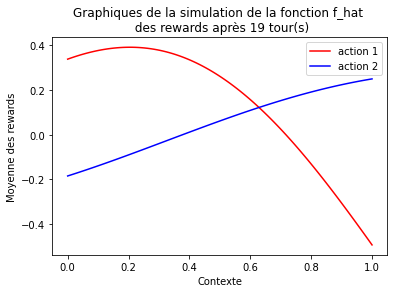

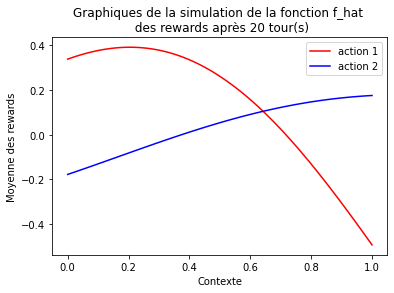

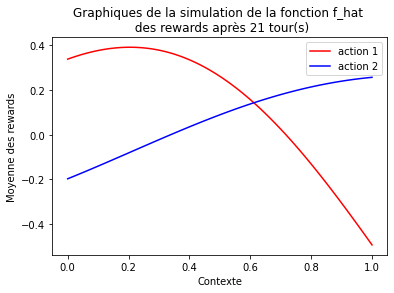

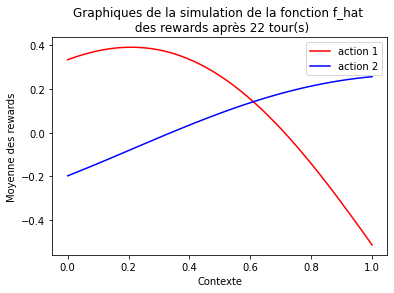

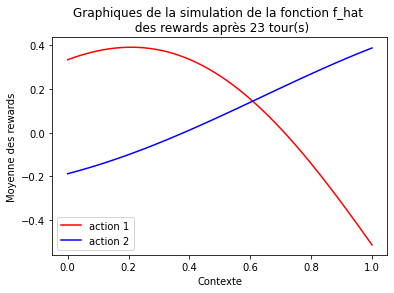

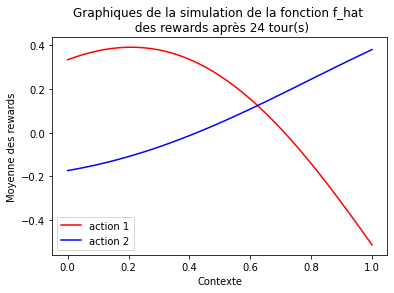

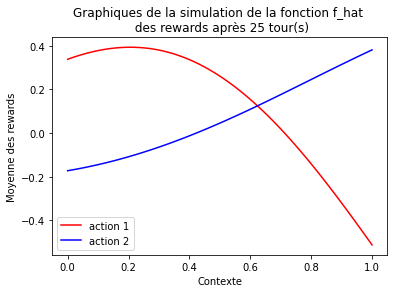

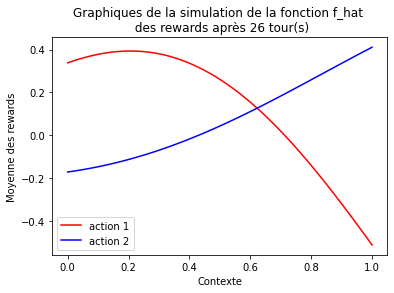

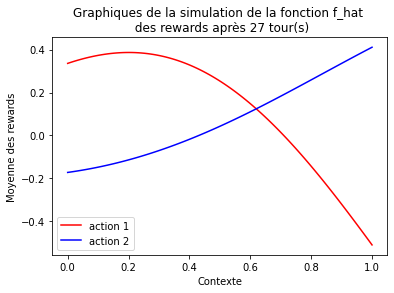

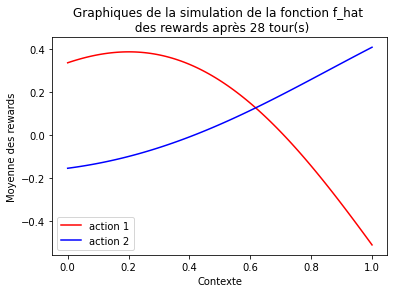

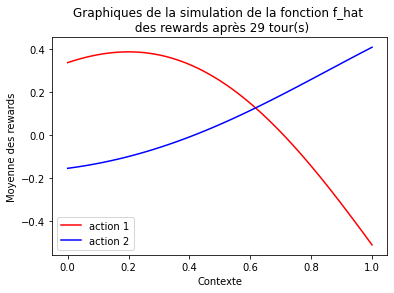

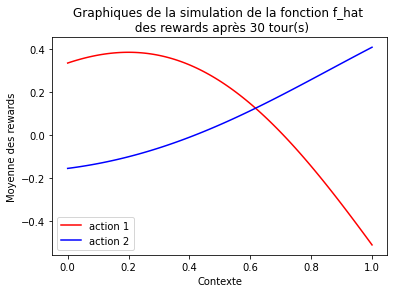

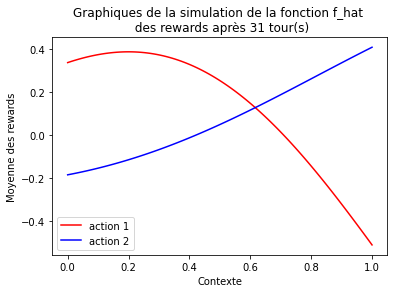

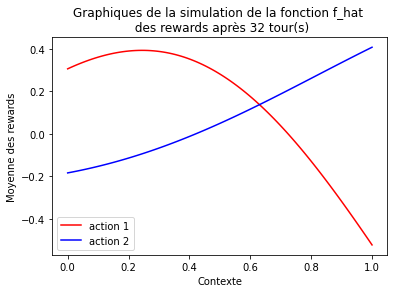

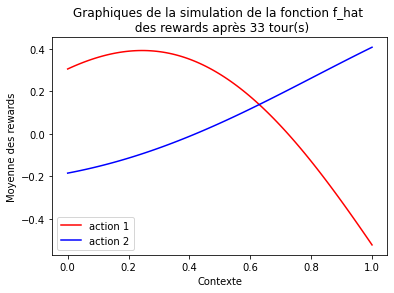

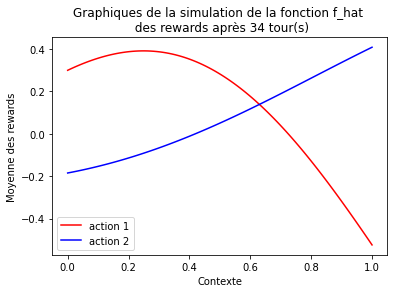

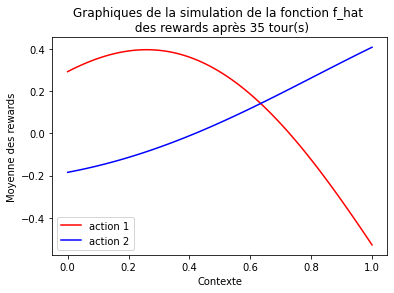

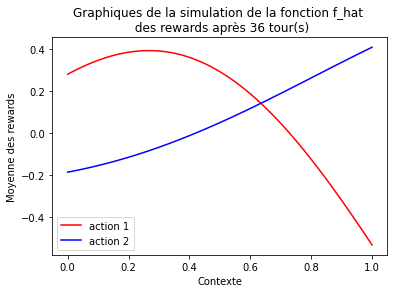

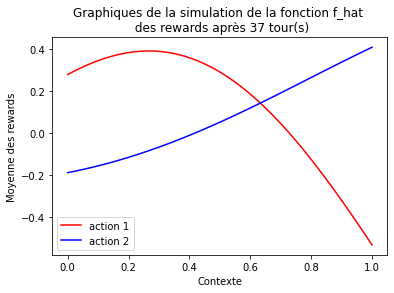

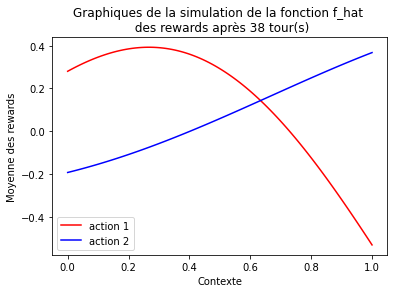

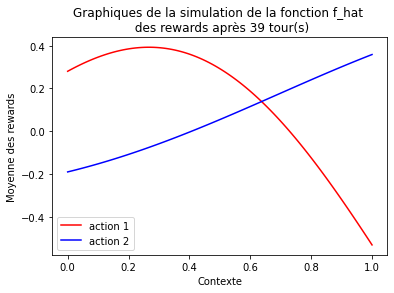

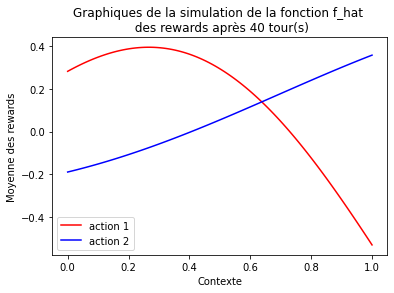

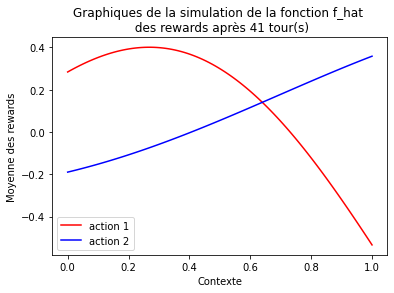

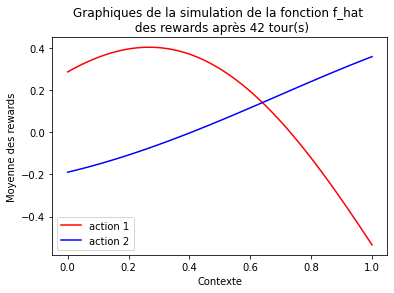

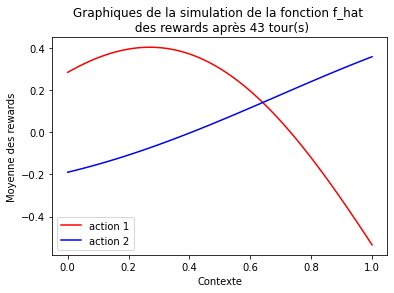

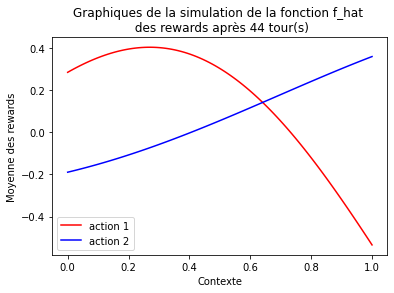

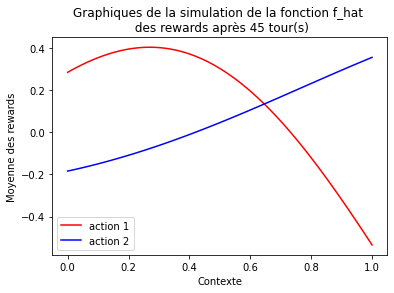

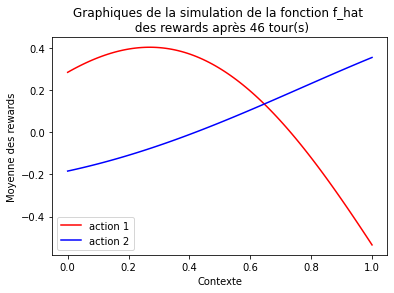

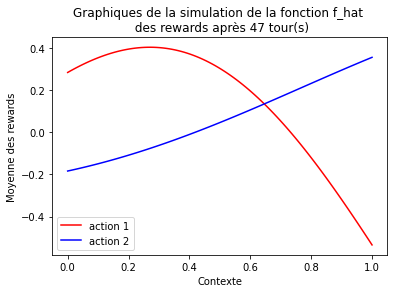

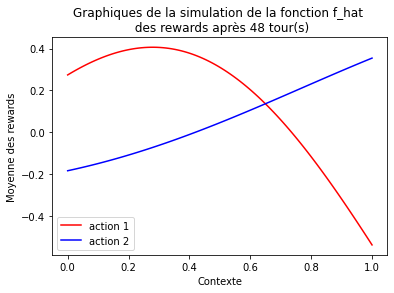

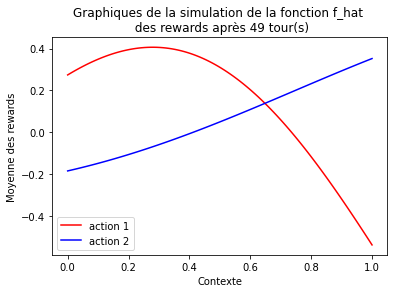

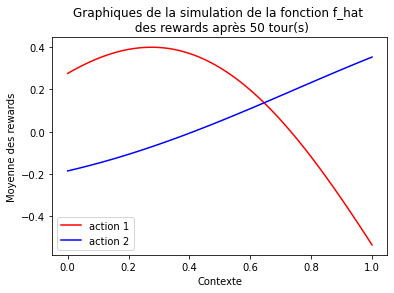

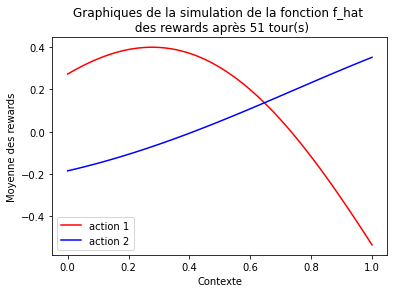

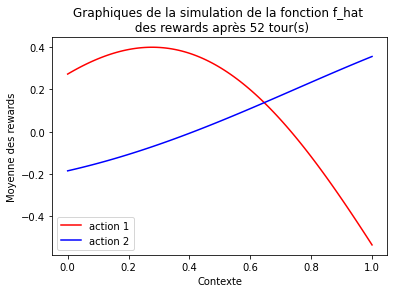

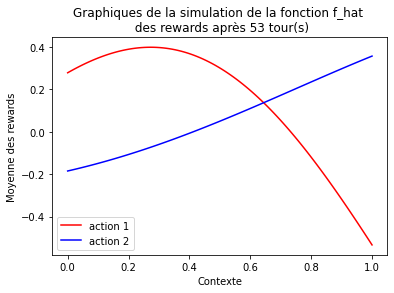

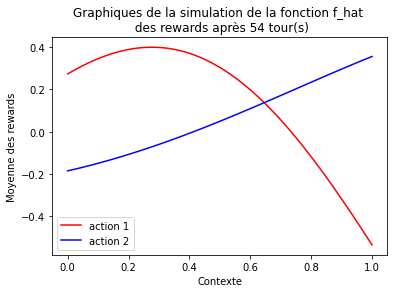

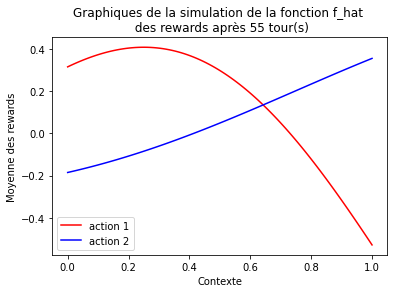

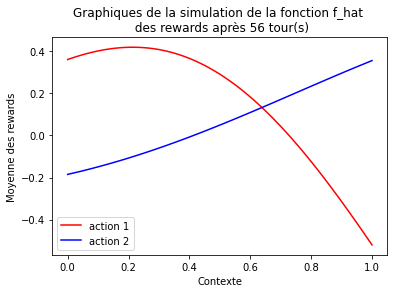

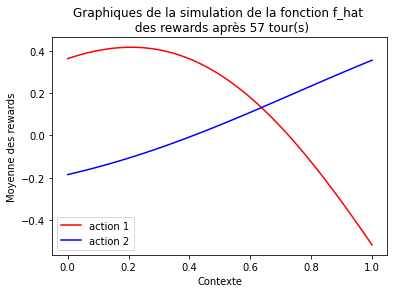

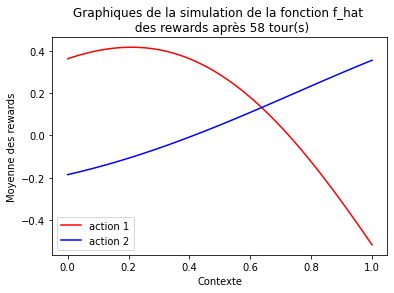

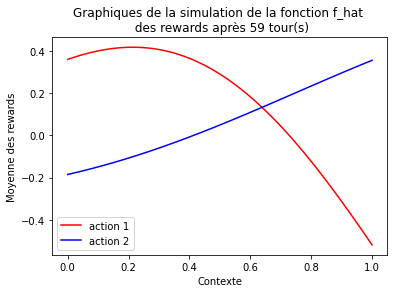

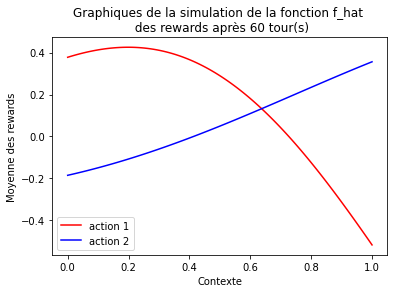

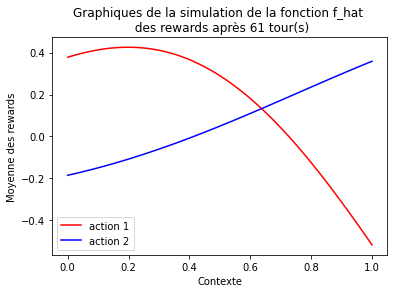

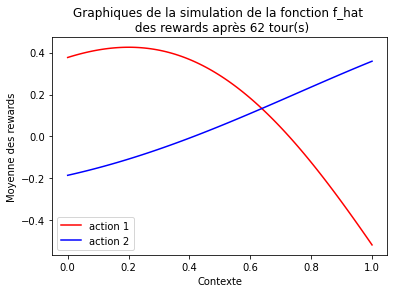

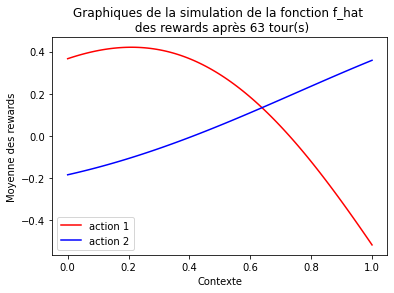

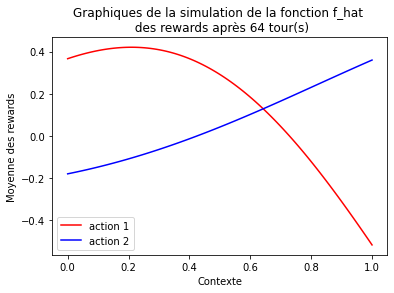

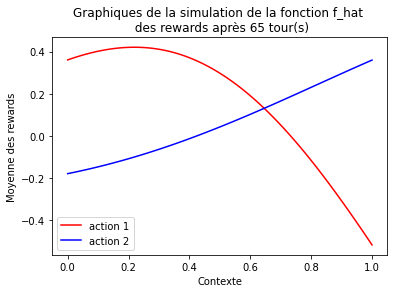

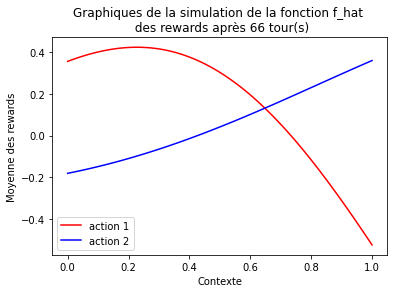

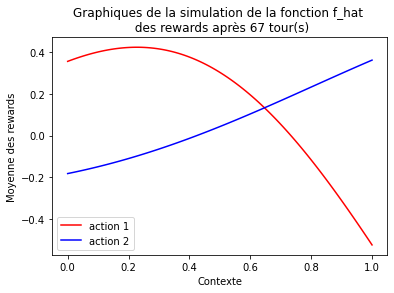

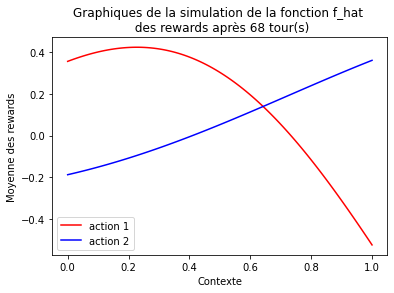

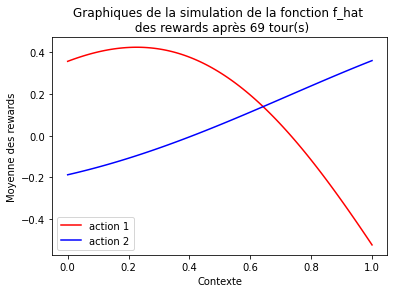

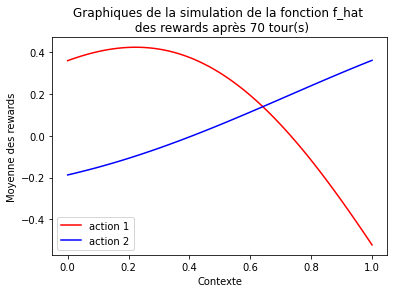

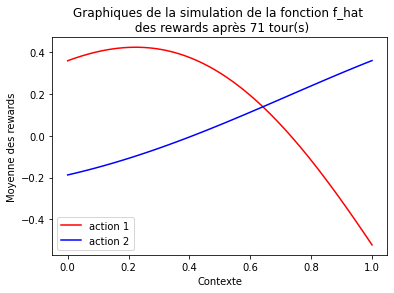

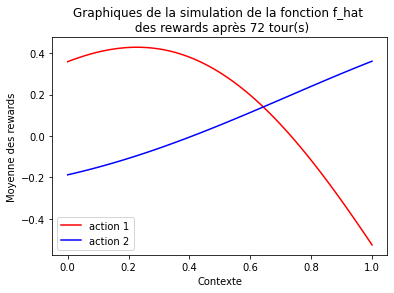

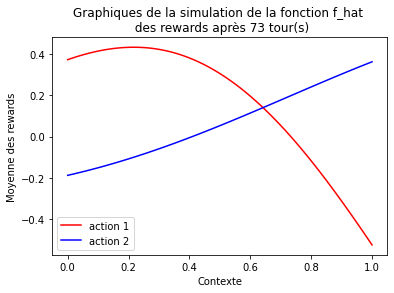

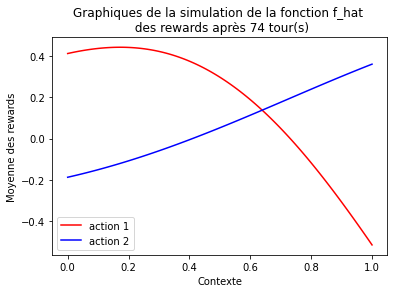

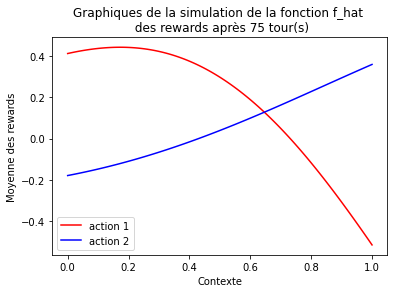

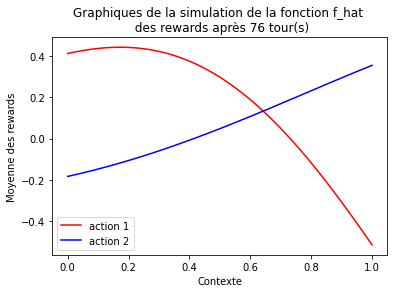

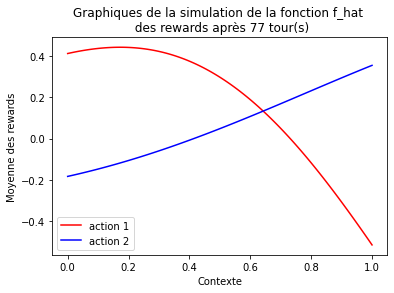

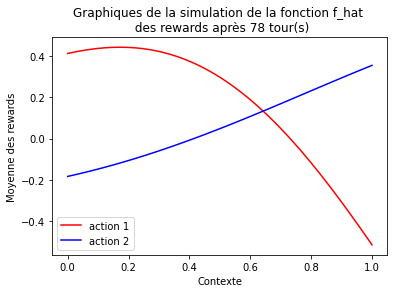

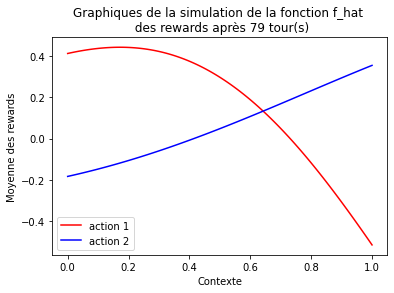

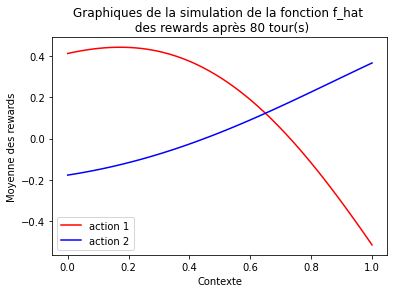

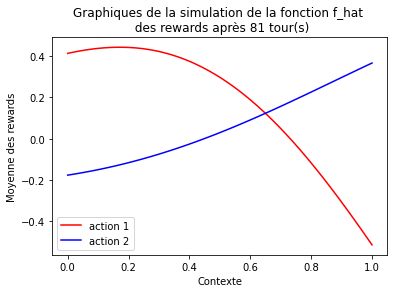

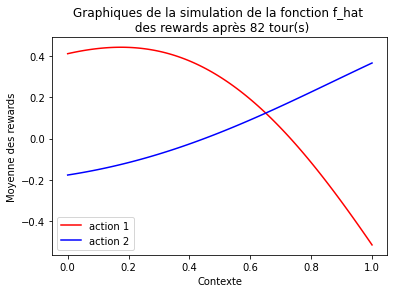

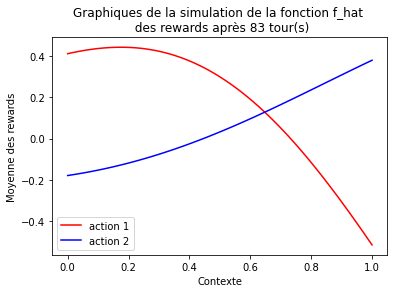

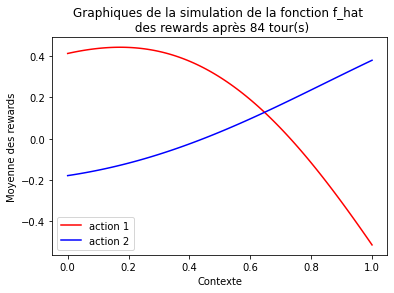

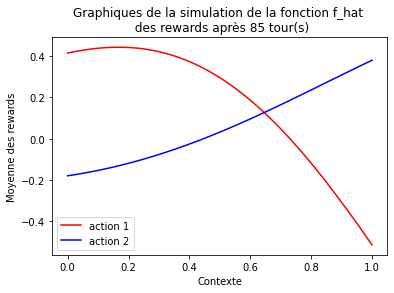

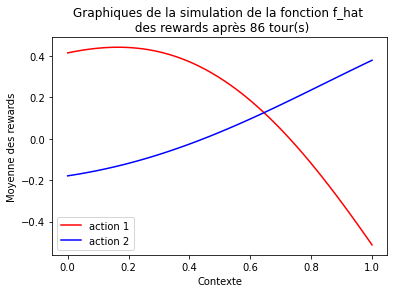

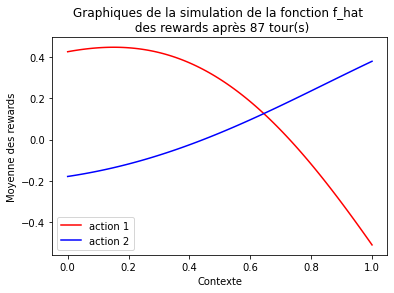

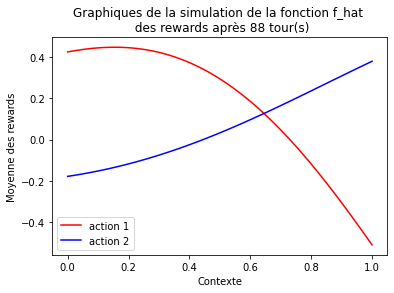

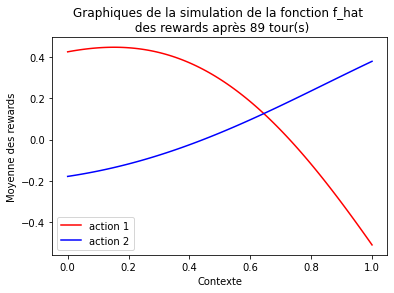

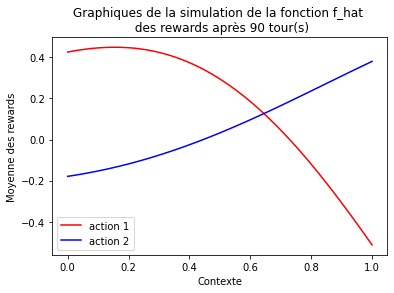

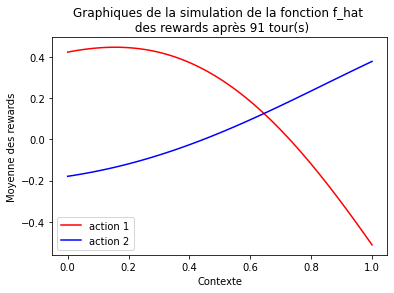

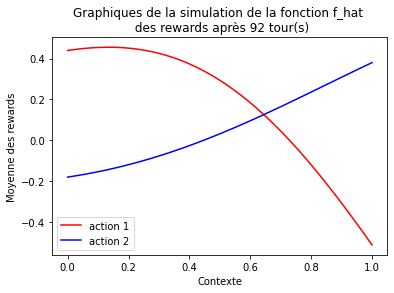

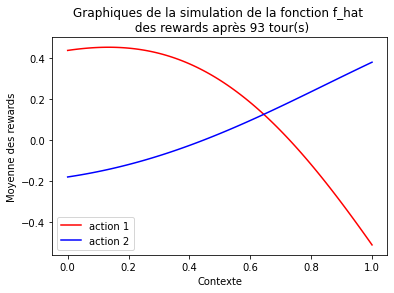

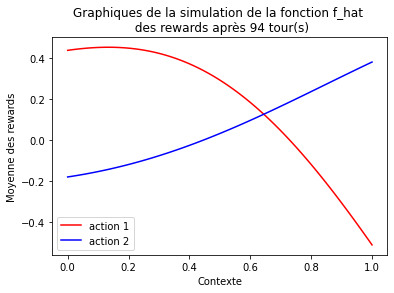

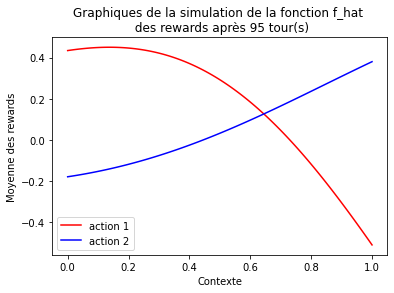

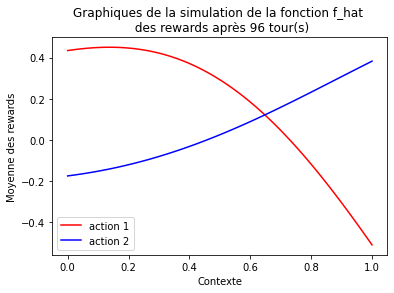

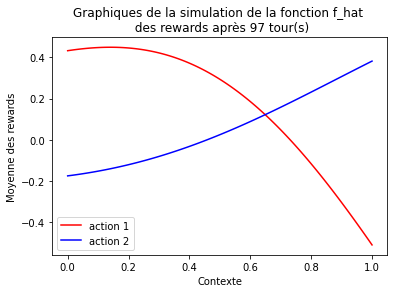

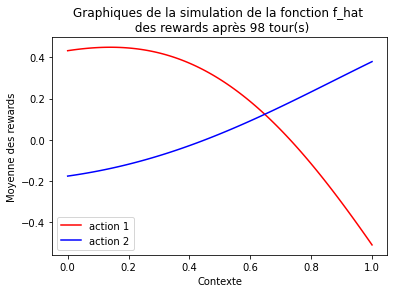

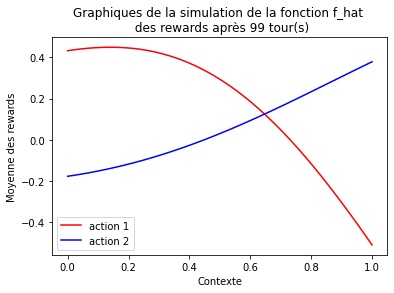

In [5]:
#Test de l'algorithme
kernel_ts_sampling_contextuel(bandit, T, Lambda, R, seed=2, plot=True)

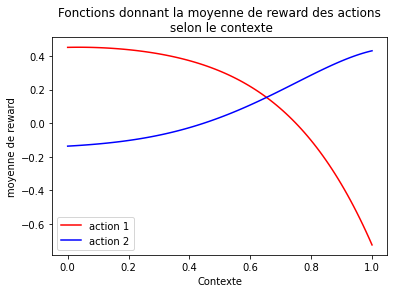

In [6]:
#Préparation d'un contexte pour tester l'algorithme de kernel Thompson Sampling sur des bandits contextuels.

space = np.linspace(0,1,100)

features_1 = np.array([[1, x, x**2, x**3, x**4, x**5] for x in space])
features_2 = np.array([[1, x, x**2, x**3, x**4, x**5] for x in space])

features = [features_1,features_2]

random = np.random.RandomState(999)
theta_1 = random.uniform(-1,1,6)
theta_2 = random.uniform(-1,1,6)


theta_1 = theta_1/np.linalg.norm(theta_1,2)
theta_2 = theta_2/np.linalg.norm(theta_2,2)

Theta=np.array([theta_1,theta_2])

sigma = 0.1

bandit = ContextBandit(space, features, Theta, sigma, 42)

#print(bandit.gaps)

T=1000
Lambda=sigma**2
R=sigma

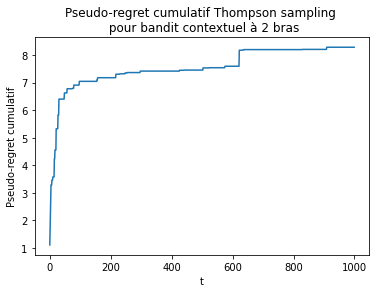

In [7]:
#Test de l'algorithme avec matrice de variances, covariances nulles au départ
kernel_ts_sampling_contextuel(bandit, T, Lambda, R, seed=2)

plt.plot(bandit.get_cumulative_regret())
plt.xlabel('t')
plt.ylabel('Pseudo-regret cumulatif')
plt.title('Pseudo-regret cumulatif Thompson sampling \n pour bandit contextuel à 2 bras')
plt.savefig('rapport/figures/pseudo_regret_cumul_context.pdf')

In [24]:
#Préparation d'un contexte pour tester l'algorithme de kernel Thompson Sampling sur des bandits contextuels.

space = np.linspace(0,1,100)

features_1 = np.array([[1, x, x**2, x**3, x**4, x**5] for x in space])
features_2 = np.array([[1, x, x**2, x**3, x**4, x**5] for x in space])

features = [features_1,features_2]

random = np.random.RandomState(999)

bandits = []
for i in range(5):
    theta_1 = random.uniform(-1,1,6)
    theta_2 = random.uniform(-1,1,6)

    theta_1 = theta_1/np.linalg.norm(theta_1,2)
    theta_2 = theta_2/np.linalg.norm(theta_2,2)

    Theta=np.array([theta_1,theta_2])

    sigma = 0.1
    

    bandits.append(ContextBandit(space, features, Theta, sigma, 42))

#print(bandit.gaps)

T=500
Lambda=sigma**2
R=sigma

In [25]:
cumul_regret = []
for bandit in bandits:
    kernel_ts_sampling_contextuel(bandit, T, Lambda, R, seed=2)
    cumul_regret.append(bandit.get_cumulative_regret())
    



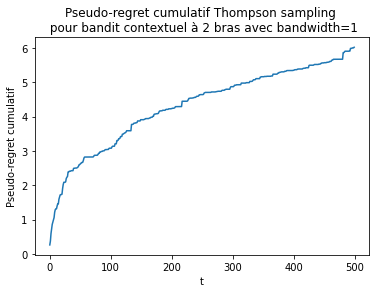

In [27]:
mean_cumul_regret = np.mean(cumul_regret, axis = 0)
plt.plot(mean_cumul_regret)
plt.xlabel('t')
plt.ylabel('Pseudo-regret cumulatif')
plt.title('Pseudo-regret cumulatif Thompson sampling \n pour bandit contextuel à 2 bras avec bandwidth=1')
plt.show()
plt.savefig('rapport/figures/regret_cumul_bw1.png')

In [28]:
#Préparation d'un contexte pour tester l'algorithme de kernel Thompson Sampling sur des bandits contextuels.

space = np.linspace(0,1,100)

features_1 = np.array([[1, x, x**2, x**3, x**4, x**5] for x in space])
features_2 = np.array([[1, x, x**2, x**3, x**4, x**5] for x in space])

features = [features_1,features_2]

random = np.random.RandomState(999)

bandits = []
for i in range(5):
    theta_1 = random.uniform(-1,1,6)
    theta_2 = random.uniform(-1,1,6)

    theta_1 = theta_1/np.linalg.norm(theta_1,2)
    theta_2 = theta_2/np.linalg.norm(theta_2,2)

    Theta=np.array([theta_1,theta_2])

    sigma = 0.1
    

    bandits.append(ContextBandit(space, features, Theta, sigma, 42))

#print(bandit.gaps)

T=500
Lambda=sigma**2
R=sigma

In [29]:
cumul_regret = []
for bandit in bandits:
    kernel_ts_sampling_contextuel(bandit, T, Lambda, R, seed=2, bw=2)
    cumul_regret.append(bandit.get_cumulative_regret())
    


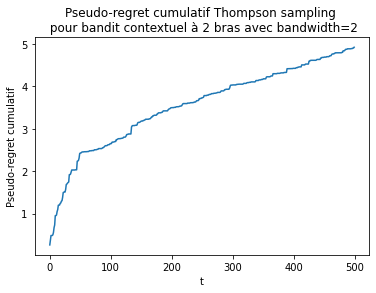

In [30]:
mean_cumul_regret = np.mean(cumul_regret, axis = 0)
plt.plot(mean_cumul_regret)
plt.xlabel('t')
plt.ylabel('Pseudo-regret cumulatif')
plt.title('Pseudo-regret cumulatif Thompson sampling \n pour bandit contextuel à 2 bras avec bandwidth=2')
plt.show()
plt.savefig('rapport/figures/regret_cumul_bw2.png')